<a href="https://colab.research.google.com/github/joaovitordeon/ML_diabetes/blob/master/supervisionado_diabetes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV

from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import MinMaxScaler


In [0]:
df = pd.read_excel('diabetes_Ex1.xlsx')

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 776 entries, 0 to 775
Data columns (total 18 columns):
A              768 non-null float64
B              768 non-null float64
C              774 non-null object
D              768 non-null float64
E              768 non-null float64
F              768 non-null float64
G              768 non-null float64
H              768 non-null float64
I              768 non-null float64
J              768 non-null float64
K              768 non-null float64
L              768 non-null float64
M              768 non-null float64
N              768 non-null float64
O              768 non-null float64
P              768 non-null float64
Unnamed: 16    0 non-null float64
Diagnóstico    768 non-null float64
dtypes: float64(17), object(1)
memory usage: 109.2+ KB


**Coluna 'Unnamed: 16' com todos os dados nulos**

In [0]:
df.drop(columns='Unnamed: 16', inplace=True)
df.dropna(inplace=True, axis='index')

In [0]:
df=df.astype(float)

In [0]:
import warnings
warnings.filterwarnings("ignore")

def split_data(clf,features,labels, folds = 10): 
    
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []

    sss = StratifiedShuffleSplit(n_splits=folds,random_state=42, test_size=0.25)
    
    #print("Making predictions... \n")
    for train_idx, test_idx in sss.split(features, labels):
        X_train = []
        X_test  = []
        y_train = []
        y_test  = []

        for ii in train_idx:
            X_train.append( features.loc[ii] )
            y_train.append( labels.loc[ii] )
        for jj in test_idx:
            X_test.append( features.loc[jj] )
            y_test.append( labels.loc[jj] )
        
        try:
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)

            accuracy_scores.append(accuracy_score(y_test, y_pred))
            precision_scores.append(precision_score(y_test, y_pred))
            recall_scores.append(recall_score(y_test, y_pred))
            f1_scores.append(f1_score(y_test, y_pred))
        except e:
            print(e)
            
    print('Accuracy', np.round( np.mean(accuracy_scores) ,3) )
    print('Precision', np.round( np.mean(precision_scores) ,3) )
    print('Recall', np.round( np.mean(recall_scores), 3) )
    print('F1-measure', np.round( np.mean(f1_scores), 3) )
    
    return np.round( np.mean(f1_scores), 3)
    

## Knn

**Colunas 1,2 são as que melhor explicam os dados**

In [0]:
# 's' para scaler e 'ws' para without scaler
def knn_func(n):
  recall_s=[]
  recall_ws=[]
  
  X =  df.drop(columns='Diagnóstico')
  y = df['Diagnóstico']
  scaler = MinMaxScaler()
  X = scaler.fit_transform(X)
  X = pd.DataFrame(X)
    
  print("Making predictions... \n")

  for i in range(2,n+1):  
    knn = KNeighborsClassifier(n_neighbors=i)
    #without scale
    recall_s.append( split_data(knn, df.drop(columns='Diagnóstico'), df['Diagnóstico']) )
    #with scale
    recall_ws.append( split_data(knn, X , y))
                 
  plt.plot(range(2,n+1) ,recall_s, color='g')
  plt.plot(range(2,n+1) ,recall_ws , color='orange')
  plt.xlabel('N')
  plt.ylabel('F1 SCORE')
  plt.xticks(range(2,n+1))
  plt.legend(['without scale', 'with scale'], loc='upper right')
  plt.show()  
        

Making predictions... 



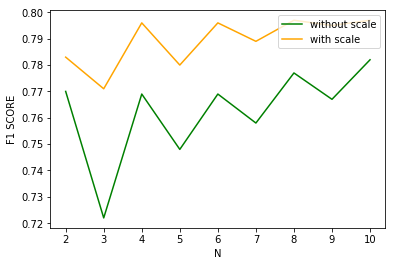

In [96]:
knn_func(10)

**RESPOSTA AQUI**

## DecisionTree


In [0]:
params={ 'criterion': ['gini', 'entropy'],
         'max_depth' : [2,4,6,8,10] ,
         'min_samples_split': [2,4,6,8,10],
         'min_samples_leaf': [2,4,6,8,10]
       }

In [128]:
dtc = DecisionTreeClassifier(random_state=42)

CV = GridSearchCV( dtc , params, cv=10)
CV.fit(df.drop(columns='Diagnóstico'),df['Diagnóstico'])
print(CV.best_params_)

{'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 10, 'min_samples_split': 2}


In [0]:
dtc= DecisionTreeClassifier(**CV.best_params_)

In [130]:
dtc.get_params

<bound method BaseEstimator.get_params of DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')>

In [131]:
split_data(dtc, df.drop(columns='Diagnóstico'), df['Diagnóstico'])

Accuracy 0.722
Precision 0.79
Recall 0.789
F1-measure 0.786


0.786

**RESPOSTA AQUI**

## GaussianNB

In [138]:
#numero de features
l=len(df.columns)-1
l

16

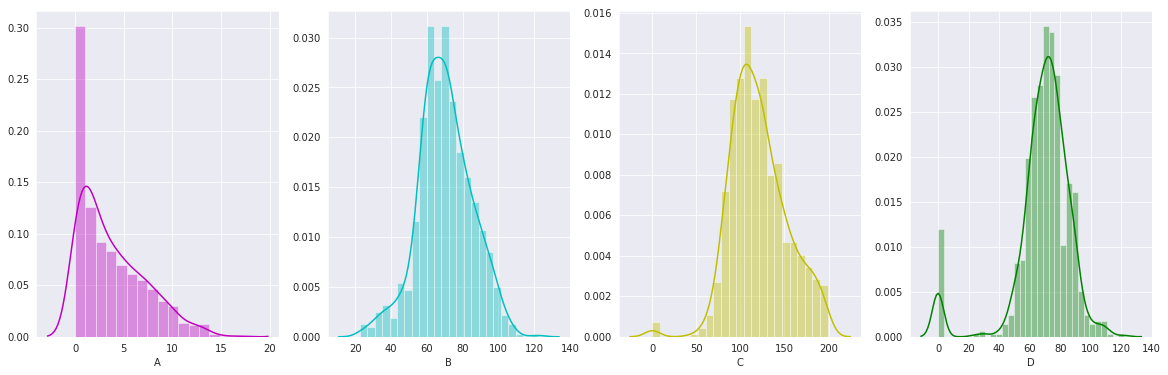

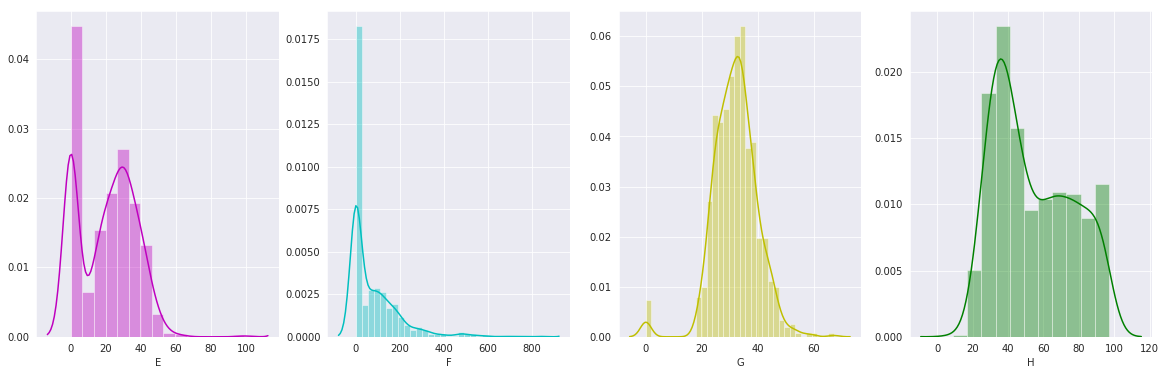

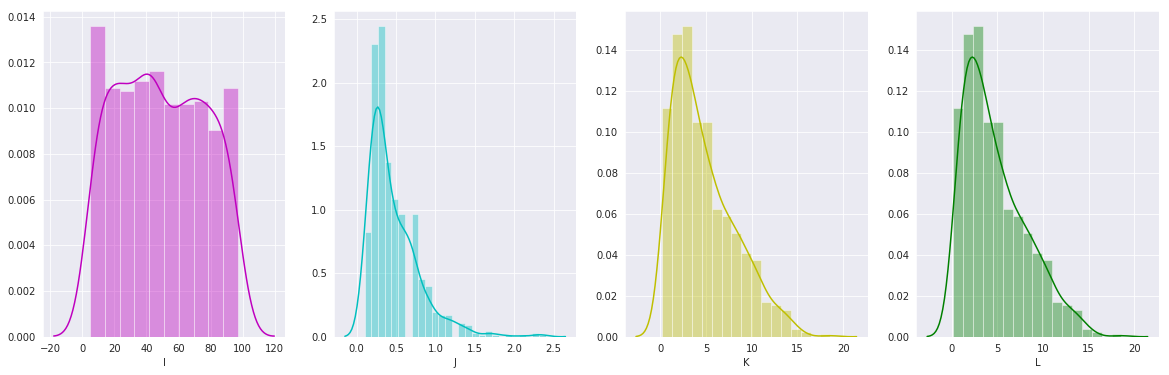

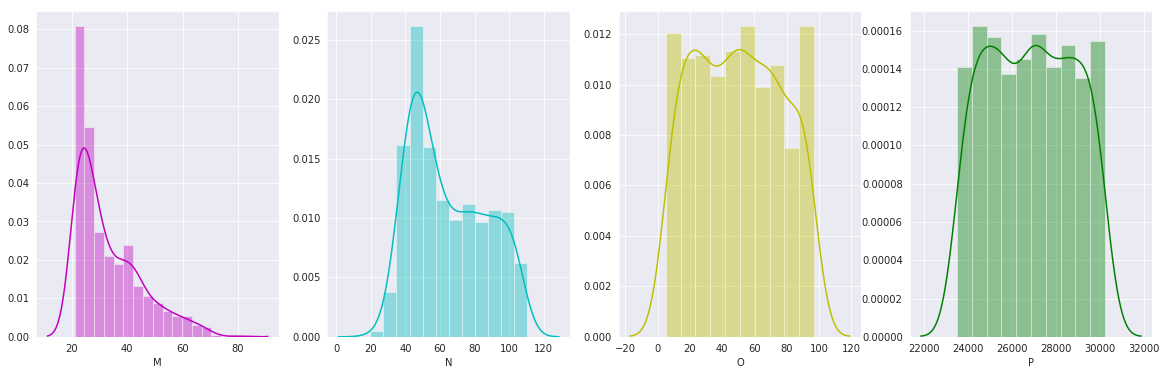

In [156]:
# ver se os dados seguem distribuição normal
sns.set_style("darkgrid")
n=0
for i in range(4):
  fig, ax = plt.subplots(1,4 ,figsize=(20,6))
  sns.distplot(df.iloc[:, n], ax=ax[0], color='m')
  n+=1
  sns.distplot(df.iloc[:, n], ax=ax[1], color='c')
  n+=1
  sns.distplot(df.iloc[:, n], ax=ax[2], color='y')
  n+=1
  sns.distplot(df.iloc[:, n], ax=ax[3], color='g')
  n+=1


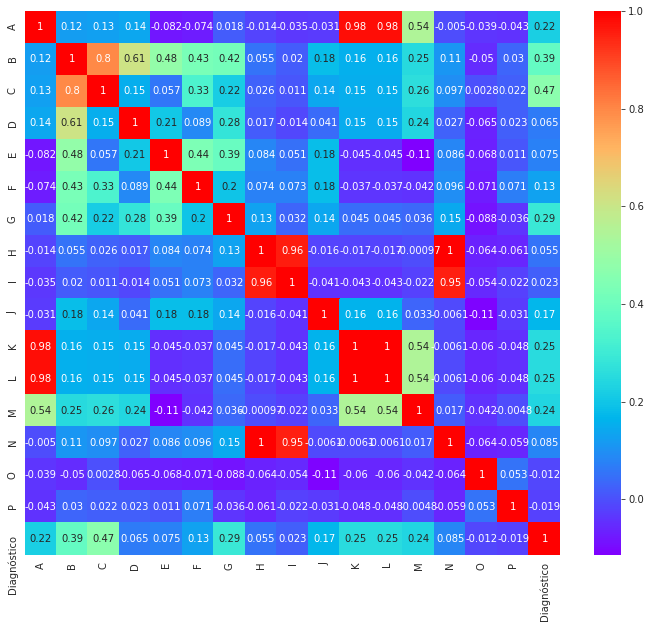

In [160]:
plt.figure(figsize=(12,10))
g = sns.heatmap(df.corr(),annot=True, cmap='rainbow')

In [0]:
gnb = GaussianNB()

In [162]:
#GaussianNB
split_data(gnb, df.drop(columns='Diagnóstico'), df['Diagnóstico'])

Accuracy 0.74
Precision 0.799
Recall 0.803
F1-measure 0.801


0.801

## MLP


In [0]:
mlp = MLPClassifier(verbose=0)

In [164]:
split_data(mlp, df.drop(columns='Diagnóstico'), df['Diagnóstico'])

Accuracy 0.585
Precision 0.726
Recall 0.729
F1-measure 0.641


0.641